In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_log_error
import lightgbm as lgb

In [3]:
XTrain = pd.read_csv("../prepared_data/train_prepared_category_3.csv")
XTest = pd.read_csv("../prepared_data/test_prepared_category_3.csv")

In [12]:
def process_data(dataframe, keep_col):
    """ columns = [
        'Unnamed: 0' 'id' 'price' 'area_total' 'area_kitchen' 'area_living'
        'floor' 'rooms' 'ceiling' 'bathrooms_shared' 'bathrooms_private'
        'windows_court' 'windows_street' 'balconies' 'loggias' 'phones'
        'building_id' 'latitude' 'longitude' 'district' 'street' 'address'
        'constructed' 'stories' 'parking' 'distance' 'distance_metro'
        'seller_0.0' 'seller_1.0' 'seller_2.0' 'seller_3.0' 'seller_nan'
        'layout_0.0' 'layout_1.0' 'layout_2.0' 'layout_nan' 'condition_0.0'
        'condition_1.0' 'condition_2.0' 'condition_3.0' 'condition_nan' 'new_0.0'
        'new_1.0' 'new_nan' 'material_0.0' 'material_1.0' 'material_2.0'
        'material_3.0' 'material_4.0' 'material_5.0' 'material_6.0'
        'material_nan' 'garbage_chute_0.0' 'garbage_chute_1.0'
        'garbage_chute_nan' 'heating_0.0' 'heating_1.0' 'heating_2.0'
        'heating_3.0' 'heating_nan' 'elevator' 'elevator_no'
    ] """

    remove_columns = ['street', 'address', 'building_id', 'id', 'price', 'Unnamed: 0']
    
    """ remove_columns.extend(['seller_0.0', 'seller_1.0', 'seller_2.0', 'seller_3.0', 'seller_nan',
        'layout_0.0', 'layout_1.0', 'layout_2.0', 'layout_nan', 'condition_0.0',
        'condition_1.0', 'condition_2.0', 'condition_3.0', 'condition_nan', 'new_0.0',
        'new_1.0', 'new_nan', 'material_0.0', 'material_1.0', 'material_2.0',
        'material_3.0', 'material_4.0', 'material_5.0', 'material_6.0',
        'material_nan', 'garbage_chute_0.0', 'garbage_chute_1.0',
        'garbage_chute_nan', 'heating_0.0', 'heating_1.0', 'heating_2.0',
        'heating_3.0', 'heating_nan', 'elevator', 'elevator_no']) """

    for col in keep_col:
        remove_columns.remove(col)

    dataframe = dataframe.drop(remove_columns, axis=1)

    """for column in dataframe.columns.values:
        #Finding the mean of the column having NaN
        mean_value=dataframe[column].mean()
        
        # Replace NaNs in column S2 with the
        # mean of values in the same column
        dataframe[column].fillna(value=mean_value, inplace=True) """

    return dataframe

C:\Users\erikm\AppData\Local\Temp/ipykernel_14424/1859354658.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  X_train = X_train[(train_data["price"] < qhigh)]


0
Test RMSLE: 0.223


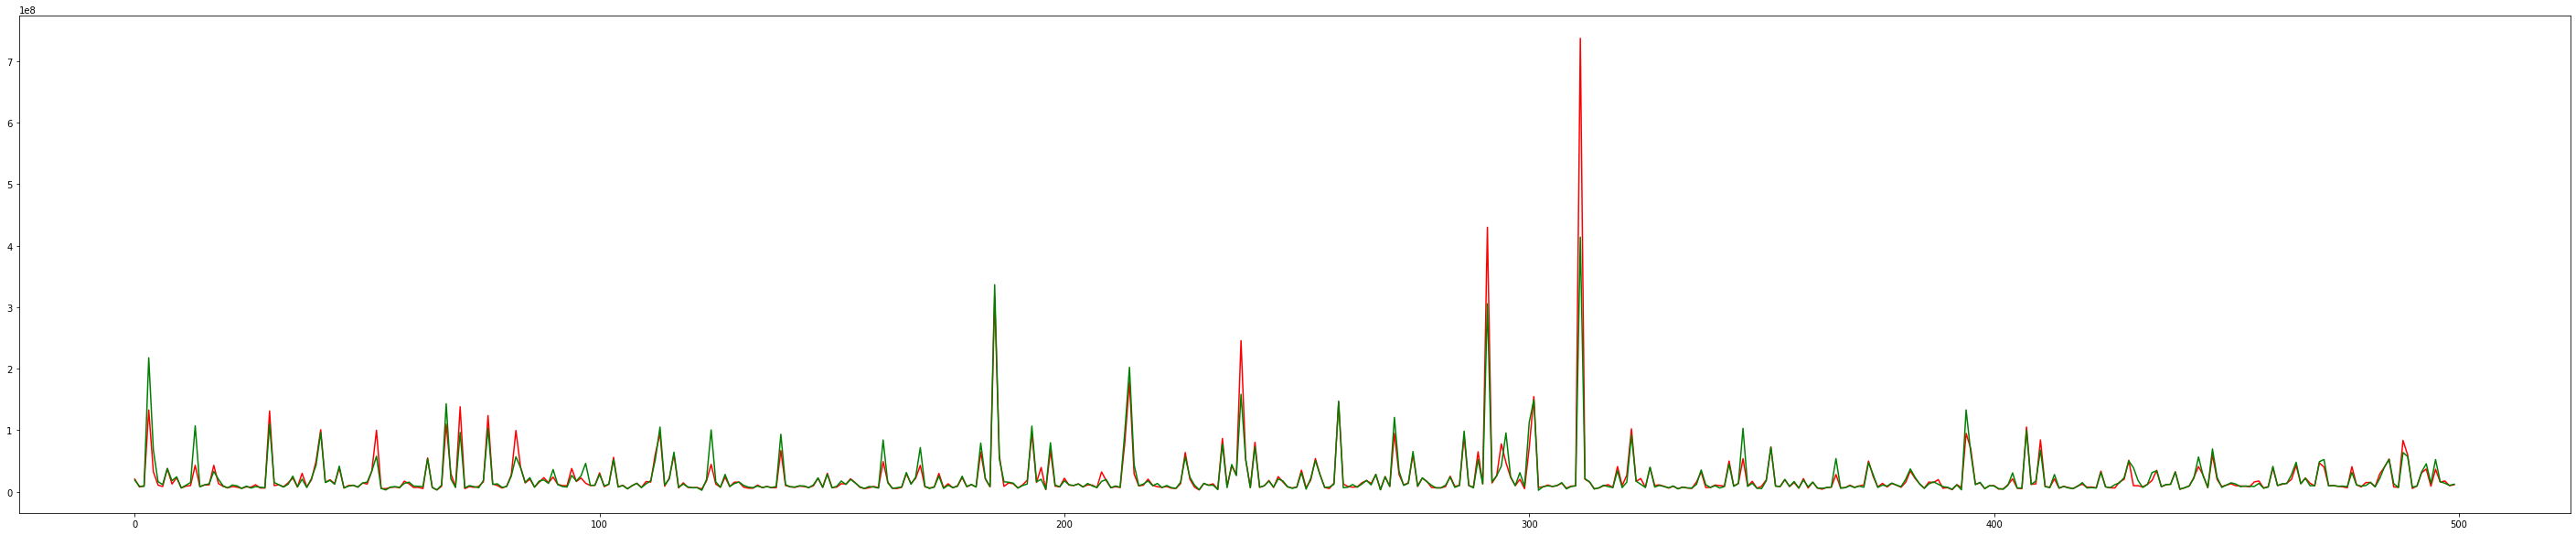

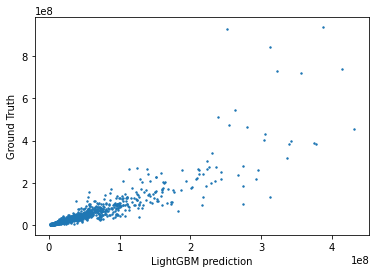

In [15]:
# process training data
train_data = XTrain.copy()
train_data = process_data(train_data, keep_col=['price'])

# split training data into test and training split
X_train, X_test = train_test_split(train_data, test_size=0.15, random_state=42)

# remove apartments with very high price from training data
qhigh = X_train["price"].quantile(0.999)
X_train = X_train[(train_data["price"] < qhigh)]

# get price columns 
y_train = X_train.pop("price")
y_test = X_test.pop("price")

model5 = lgb.LGBMRegressor(
    num_leaves=100,
    max_depth=10, 
    random_state=42,
    metric='rmsle',
    n_jobs=4, 
    n_estimators=3000,
    colsample_bytree=0.95,
    subsample=0.9,
    learning_rate=0.05
)

model5.fit(X_train, y_train)

lgbm_prediction = model5.predict(X_test)

faulty_rows = []
for i in range(len(lgbm_prediction)):
    if lgbm_prediction[i] < 900000:
        lgbm_prediction[i] = 900000
        faulty_rows.append(i)

# list apartments resulting in too low price
print(len(faulty_rows))

lgb_rmsle = round(np.sqrt(mean_squared_log_error(lgbm_prediction, y_test)), 3)
print('Test RMSLE:', lgb_rmsle)

# red is real prices, green is predicted prices
plt.figure(figsize=(50, 10))
plt.plot(y_test.values[:500], color = 'red')
plt.plot(lgbm_prediction[:500], color = 'green')
plt.show()

# correct predictions are on the diagonal
plt.scatter(lgbm_prediction, y_test, s=2)
plt.xlabel('LightGBM prediction')
plt.ylabel('Ground Truth')
plt.show()

In [16]:
# normalize columns test data
test_data = XTest.copy()
test_data = process_data(test_data, keep_col=['id', 'price'])

# separate id from test data
ids = test_data.pop("id")

# predict
predictions = model5.predict(test_data)

# replace negative predictions and low predicitons with lowest price in dataset (not ideal)
for i in range(len(predictions)):
    if predictions[i] < 900000:
        predictions[i] = 900000

# create submission file
submission = pd.DataFrame(data=ids.values, columns=["id"])
submission["price_prediction"] = predictions
submission.to_csv("lgbm_predictions.csv", index=False)